In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from glob import glob
from tqdm import tqdm
import xarray as xr
import os, sys
import scipy
import pandas as pd
from scipy.ndimage import gaussian_filter, gaussian_filter1d
from sklearn.decomposition import PCA
from scipy import stats

sys.path.append('../scripts/')
from LPA import LPA_Signal

sys.path.append('../scripts/icsd_scripts/')
from data_processing_before_lpa import *

from scipy import interpolate

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

#from utils import *

In [3]:
# for plotting
plt.rcParams.update({'font.size': 16})

In [217]:
dir_to_data = '/Users/atleeskelandrimehaug/OneDrive - Universitetet i Oslo/PhD/CINPLA/check_repos/CINPLA_Allen_V1_analysis_after_review'

exp_meta_data_dir = os.path.join(dir_to_data, 'meta_data/exp')
exp_data_dir = os.path.join(dir_to_data, 'processed_data/exp')

fig_dir = 'Figures/Figure_drafting_nov_23/Supplementary_figures'

# Load data from experiments

In [6]:
# Load meta data
manifest_path = os.path.join(exp_meta_data_dir, 'ecephys_cache_dir_10_31', "manifest.json")
#manifest_path = os.path.join(exp_meta_data_dir, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

## LFP/CSD

In [7]:
channels = cache.get_channels()
probes = cache.get_probes()

# Load data from sims

### Read CSD

In [423]:
lfp_sims_all_stim = dict()

In [424]:
sim_data_dir = '/Users/atleeskelandrimehaug/Dropbox (Simula)/Data/output_sims'

selected_sims_data_dir = os.path.join(sim_data_dir, '2021', 'jan', '2022_jan_07*')

#selected_sims_data_dir = os.path.join(sim_data_dir, '2023', 'flash', 'apr', '2022_jan_07_wo_bkg')

#selected_sims_data_dir = os.path.join(sim_data_dir, '2021')

lfp_sims = find_files(selected_sims_data_dir, filename = 'lfp_w_baseline.npy')

#lfp_sims = find_files(selected_sims_data_dir, filename = 'lfp.npy')

for sim_name in list(lfp_sims.keys()):
    if 'jan_07' not in sim_name or 'fb_to_L1' in sim_name or 'w_20um' in sim_name or 'bkg' in sim_name:
        del lfp_sims[sim_name]
        
if len(lfp_sims.keys()) == 1:
    sim_name = list(lfp_sims.keys())[0]
elif len(lfp_sims.keys()) > 1:
    sim_names = list(lfp_sims.keys())
    sim_name = sim_names[0]
print(lfp_sims.keys())

for sim_name in list(lfp_sims.keys()):
    lfp_sims_all_stim[sim_name] = lfp_sims[sim_name]
    
for sim_name in list(lfp_sims.keys()):
    lfp_sims_all_stim_temp = dict()
    lfp_sims_all_stim_temp['all_trials'] = lfp_sims[sim_name]['all_trials']#[:,:,tstim_onset_sim:]
    lfp_sims_all_stim_temp['trial_avg'] = lfp_sims[sim_name]['trial_avg']#[:,tstim_onset_sim:]
    lfp_sims_all_stim[sim_name] = lfp_sims_all_stim_temp

dict_keys(['2022_jan_07', '2022_jan_07_black'])


#### Compute CSD

In [425]:
nchan_lim = 22
tstim_onset_sim = 200

In [426]:
method='DeltaiCSD'

#csd_for_lpa = np.zeros((nstim, nchan_lim, ntime))

csd_sims = dict()
for isim, sim_name in enumerate(lfp_sims_all_stim.keys()):
    print(sim_name)
    lfp_temp = lfp_sims_all_stim[sim_name]['trial_avg'][:nchan_lim]
    
    csd_temp = compute_csd(lfp_temp, method = 'delta', h = 40*1E-6*pq.m, gauss_filter = (1.4,0),
                        coord_electrodes = np.linspace(0,840E-6, lfp_temp.shape[0]) * pq.m)
    
    csd_temp = (csd_temp.T-np.mean(csd_temp[:,:tstim_onset_sim], axis = 1)).T
    
    csd_sims[sim_name] = csd_temp

2022_jan_07
2022_jan_07_black


In [428]:
csd_sims[sim_name]

array([[ -5.26143726,   2.3662863 ,   6.77476652, ...,   3.42820406,
        -18.53735441, -35.74538996],
       [-10.42305445,  -9.78858448,  -8.57833999, ...,  -3.28092226,
        -15.24979121, -28.65582088],
       [ -5.79084968, -12.68301803, -13.71036158, ...,   8.94717506,
         14.62833252,   8.13890689],
       ...,
       [  1.95117077,   6.13736347,  27.98035693, ...,  78.79117713,
         78.819063  ,  76.33294134],
       [-16.7651993 ,  -9.41248471,  -4.58069986, ..., 120.65826441,
        106.28866506, 104.20840695],
       [-28.53234977,  -3.67472989,  -7.02643665, ..., 105.92453158,
         93.13594424, 107.41748437]]) * A/m**3

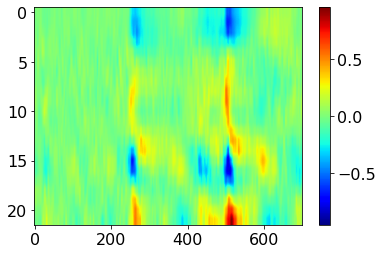

In [431]:
scale_to_uA = 1E-3
csd_orig_plot = csd_sims[sim_name]*scale_to_uA

#csd_plot = (csd_orig_plot.T-np.mean(csd_orig_plot[:,:tstim_onset_sim], axis = 1)).T

cmap_range = np.abs(csd_orig_plot).max()

plt.imshow(csd_orig_plot, cmap = 'jet', vmin = -cmap_range, vmax = cmap_range, aspect = 'auto')

plt.colorbar()

In [10]:
import numpy as np
from scipy import signal

np.random.seed(0)
n_samples = 2000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: saw tooth signal

S = np.c_[s1, s2, s3]
#S = s1 + s2 + s3
S += 0.2 * np.random.normal(size=S.shape)  # Add noise

S /= S.std(axis=0)  # Standardize data
# Mix data
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations

In [11]:
from sklearn.decomposition import FastICA, PCA

# Compute ICA
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

# We can `prove` that the ICA model applies by reverting the unmixing.
assert np.allclose(X, np.dot(S_, A_.T) + ica.mean_)

# For comparison, compute PCA
pca = PCA(n_components=1)
H = pca.fit_transform(X)  # Reconstruct signals based on orthogonal components

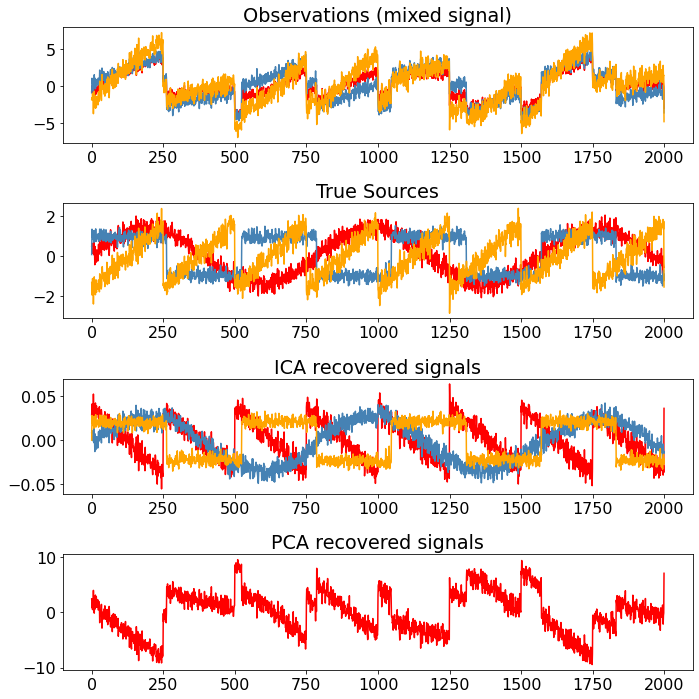

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,10))

models = [X, S, S_, H]
names = [
    "Observations (mixed signal)",
    "True Sources",
    "ICA recovered signals",
    "PCA recovered signals",
]
colors = ["red", "steelblue", "orange"]

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.tight_layout()
plt.show()

In [27]:
sims_sinks = dict()
sims_sources = dict()

sims_csd_interp = dict()

factor = 4
sp_len = 22; t_len = 700
n_chans_in_cortex_sim = 22
for sim_name in csd_sims.keys():
    z = csd_sims[sim_name][:n_chans_in_cortex_sim,:]
    x = np.linspace(0., 1., z.shape[1], endpoint=True)
    y = np.linspace(0., 1., z.shape[0], endpoint=True)
    #xx, yy = np.meshgrid(x, y)
    f = interpolate.interp2d(x, y, z, kind='cubic')
    
    sp_len = factor*z.shape[0]

    x_new = np.linspace(0., 1., t_len, endpoint=True)
    y_new = np.linspace(0., 1., sp_len, endpoint=True)
    csd_interp = f(x_new, y_new)

    sims_csd_interp[sim_name] = csd_interp/np.abs(csd_interp).max()

    mask_sinks = csd_interp < 0
    mask_sources = csd_interp > 0

    sinks_interp = np.zeros_like(csd_interp)
    sources_interp = np.zeros_like(csd_interp)

    sinks_interp[mask_sinks] = np.abs(csd_interp[mask_sinks])
    sources_interp[mask_sources] = np.abs(csd_interp[mask_sources])

    sims_sinks[sim_name] = sinks_interp / sinks_interp.sum()
    sims_sources[sim_name] = sources_interp / sources_interp.sum()


    sims_sinks_list = np.array(list(sims_sinks.values()))
    sims_sources_list = np.array(list(sims_sources.values()))

In [28]:
sims_csd_ica = dict()
sims_mixing_mat = dict()

n_components = 4
for sim_name in sims_csd_interp.keys():
    csd_sim_interp = sims_csd_interp[sim_name]
    
    transformer = FastICA(n_components=n_components,
                     random_state=0,
                     whiten='unit-variance')
    X_transformed = transformer.fit_transform(csd_sim_interp.T).T
    
    sims_mixing_mat[sim_name] = transformer.mixing_
    #print(X_transformed.shape)
    
    sims_csd_ica[sim_name] = X_transformed

In [29]:
sims_csd_ica[sim_name].shape

(4, 700)

In [15]:
csd_sims[sim_name].shape

(22, 700)

In [43]:
csd_sims_ica = dict()
sims_mixing_mat = dict()

n_components = 4
for sim_name in csd_sims.keys():
    csd_sim = csd_sims[sim_name]
    
    transformer = FastICA(n_components=n_components,
                     random_state=0,
                     whiten='unit-variance')
    X_transformed = transformer.fit_transform(csd_sim.T).T
    
    sims_mixing_mat[sim_name] = transformer.mixing_
    #print(X_transformed.shape)
    
    csd_sims_ica[sim_name] = X_transformed

In [57]:
csd_sims_arr = np.array(list(csd_sims.values()))

csd_sims_arr_flat = np.zeros((csd_sims_arr.shape[1], csd_sims_arr.shape[0]*csd_sims_arr.shape[-1]))

for istim in range(csd_sims_arr.shape[0]):
    
    csd_sims_arr_flat[:, istim*csd_sims_arr.shape[-1]:(istim+1)*csd_sims_arr.shape[-1]] = csd_sims_arr[istim]

In [59]:
csd_sims_arr_flat.shape

(22, 1400)

In [62]:
csd_sim

(22, 700)

In [63]:

n_components = 4

transformer = FastICA(n_components=n_components,
                     random_state=0,
                     whiten='unit-variance')
X_transformed = transformer.fit_transform(csd_sims_arr_flat.T).T

mixing_mat_flat = transformer.mixing_
#print(X_transformed.shape)

csd_sims_flat_ica = X_transformed

In [85]:

csd_sims_recon = dict()
for istim, stim_name in zip(range(2), ['white', 'black']):
    csd_stim_comps = []
    for compNr in range(n_components):
        csd_recon = np.outer(csd_sims_flat_ica[compNr], mixing_mat_flat[:,compNr]).T
        
        csd_stim_comps.append(csd_recon[:, istim*700:(istim+1)*700])
        
    csd_sims_recon[stim_name] = np.array(csd_stim_comps)

In [94]:
csd_sims_recon[stim_name].shape

(4, 22, 700)

In [95]:
csd_recon.shape

(4, 22, 700)

In [96]:
csd_plot

array([[  1.51616378,  -0.55464683,   0.20810023, ...,   2.33255998,
         11.36560149,  15.31126854],
       [  1.47550804,  -0.53977405,   0.20252005, ...,   2.27001268,
         11.06083433,  14.90069882],
       [  1.35949812,  -0.49733501,   0.18659717, ...,   2.09153585,
         10.19119046,  13.72915055],
       ...,
       [ -1.73325099,   0.63406222,  -0.23789641, ...,  -2.66654033,
        -12.99294983, -17.50356497],
       [ -3.35757005,   1.22827468,  -0.46084143, ...,  -5.16549306,
        -25.1693145 , -33.90706015],
       [ -4.09504328,   1.49805898,  -0.56206291, ...,  -6.30006741,
        -30.69762675, -41.35457391]])

In [161]:
ytick_step = 5
yticks = np.arange(0,26,ytick_step)
ylabel_start = 0
ylabel_stop = 1000
ytick_label_step = int((ylabel_stop-ylabel_start)/ytick_step)
ytick_labels = -np.arange(ylabel_start, ylabel_stop+ytick_label_step, ytick_label_step)

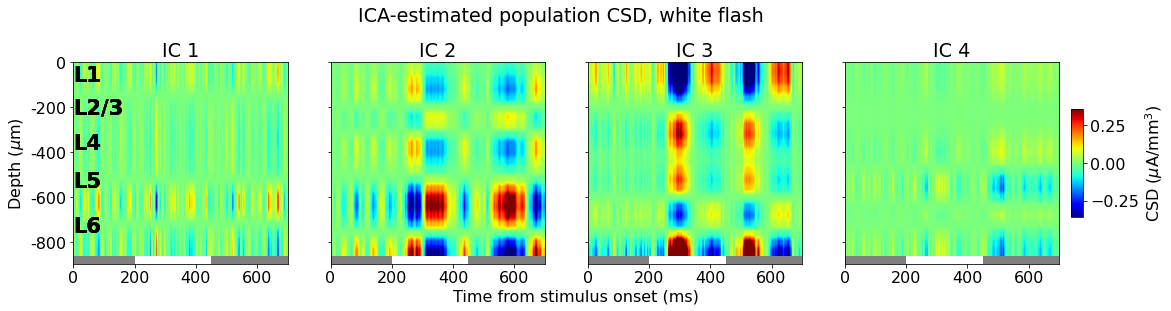

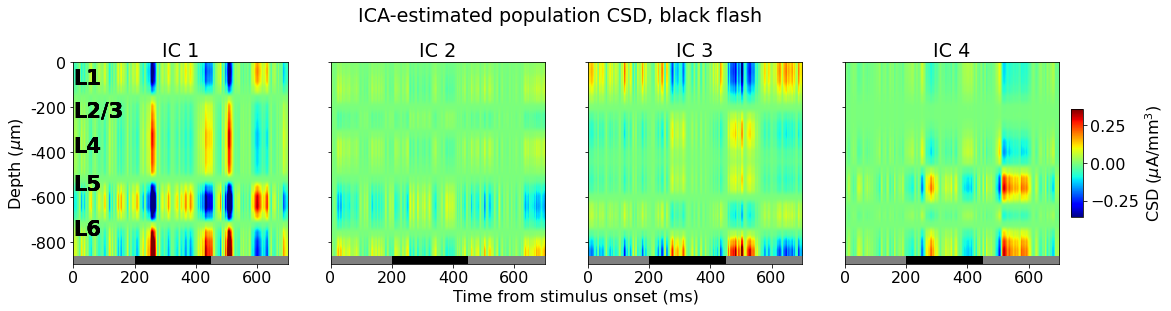

In [804]:

tstim_onset = 200
scale_to_uA = 1E-3

for istim, stim_name in enumerate(csd_sims_recon.keys()):
    fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize = (5.5*3,4.3), sharex = True, sharey = True)
        
    csd_recon = csd_sims_recon[stim_name]
    
    for compNr in range(n_components):
        ax = axes[compNr]
        
        csd_plot = csd_recon[compNr] * scale_to_uA
        
        #if compNr == 0 and istim == 0:
        #    cmap_range = np.abs(csd_plot).max()
    
        im = ax.imshow(csd_plot, cmap = 'jet', vmin = -cmap_range_gt, vmax = cmap_range_gt, aspect = 'auto')
        
        if compNr == 0:
            ax.set_yticks(yticks)
            ax.set_yticklabels(ytick_labels)
            ax.set_ylabel('Depth ($\mu$m)')
            
        if istim == 0:
            ax.hlines(y = 22.03, xmin = 0, xmax = tstim_onset, linewidth = 8.0, colors = 'gray')
            ax.hlines(y = 22.03, xmin = tstim_onset, xmax = tstim_onset+250, linewidth = 8.0, colors = 'white')
            ax.hlines(y = 22.03, xmin = tstim_onset+250, xmax = 700, linewidth = 8.0, colors = 'gray')
        elif istim == 1:
            ax.hlines(y = 22.03, xmin = 0, xmax = tstim_onset, linewidth = 8.0, colors = 'gray')
            ax.hlines(y = 22.03, xmin = tstim_onset, xmax = tstim_onset+250, linewidth = 8.0)
            ax.hlines(y = 22.03, xmin = tstim_onset+250, xmax = 700, linewidth = 8.0, colors = 'gray')
            
        ax.set_ylim([22.4, 0])
        ax.set_xlim([0, 700])
                
        plt.figtext(x = 0.07, y = 0.74-istim*0.01, s = 'L1', fontsize = 21, fontweight = 560)
        plt.figtext(x = 0.07, y = 0.635-istim*0.01, s = 'L2/3', fontsize = 21, fontweight = 560)
        plt.figtext(x = 0.07, y = 0.52-istim*0.01, s = 'L4', fontsize = 21, fontweight = 560)
        plt.figtext(x = 0.07, y = 0.395-istim*0.01, s = 'L5', fontsize = 21, fontweight = 560)
        plt.figtext(x = 0.07, y = 0.25-istim*0.01, s = 'L6', fontsize = 21, fontweight = 560)
        
        ax.set_title('IC '+str(compNr+1))
    
    cbaxes = fig.add_axes([0.91,0.3,0.01, 0.35])
    cb = fig.colorbar(im, ax = ax, cax = cbaxes)
    cb.set_label('CSD ($\mu$A/mm$^3$)')
        
    plt.figtext(s = 'Time from stimulus onset (ms)', x = 0.39, y = 0.03)
        
    fig.subplots_adjust(left = 0.07, right = 0.9, bottom = 0.15, top = 0.8)
    
    fig.suptitle('ICA-estimated population CSD, '+flash_types[istim]+' flash', x = 0.48, y = 0.98)
    
    fig_name = 'ica_est_pop_csd_'+str(flash_types[istim])+'_flashes.png'
    
    savepath = os.path.join(fig_dir, 'ICA')
    
    if not os.path.exists(savepath):
        if not os.path.exists(savepath.rsplit('/', 1)[0]):
            os.mkdir(savepath.rsplit('/', 1)[0])
            os.mkdir(savepath)
        elif not os.path.exists(savepath.rsplit('/', 1)[0].rsplit('/', 1)[0]):
            os.mkdir(savepath.rsplit('/', 1)[0].rsplit('/', 1)[0])
            os.mkdir(savepath)
        else:
            os.mkdir(savepath)
            
    savepath = os.path.join(savepath, fig_name)
    
    #fig.savefig(savepath, facecolor = 'w')

## Load ground truth data

In [225]:
flash_types = ['white', 'black']

In [226]:
#config_name = '2021_dec_16_config'
config_name = '2022_jan_07_config'

In [227]:
black_flash = False

if black_flash:
    dir_add = 'black_flash'
    filename_add = '_black'
else:
    dir_add = ''
    filename_add = ''

In [669]:
csd_gt_flashes = dict()

for istim in range(2):
    flash_type = flash_types[istim]
    if istim == 0:
        dir_add = ''
        filename_add = ''
    elif istim == 1:
        dir_add = 'black_flash'
        filename_add = '_black'
        

    # LGN
    filename = 'csd_total_lgn.npy'
    loadpath = os.path.join('..', 'ground_truth', 'replay_w_cut_sims', config_name, dir_add, filename)
    csd_sims_gt = np.load(loadpath, allow_pickle=True)[()]

    # FB
    filename = 'csd_total_fb.npy'
    loadpath = os.path.join('..', 'ground_truth', 'replay_w_cut_sims', config_name, dir_add, filename)
    csd_sims_gt_temp = np.load(loadpath, allow_pickle=True)[()]

    for sim_name in csd_sims_gt_temp.keys():
        csd_sims_gt[sim_name] = csd_sims_gt_temp[sim_name]

    # BKG
    filename = 'csd_total_bkg.npy'
    loadpath = os.path.join('..', 'ground_truth', 'replay_w_cut_sims', config_name, dir_add, filename)
    csd_sims_gt_temp = np.load(loadpath, allow_pickle=True)[()]

    for sim_name in csd_sims_gt_temp.keys():
        csd_sims_gt[sim_name] = csd_sims_gt_temp[sim_name]

    # V1    
    filename = 'csd_total.npy'
    loadpath = os.path.join('..', 'ground_truth', 'replay_w_cut_sims', config_name, dir_add, filename)
    csd_sims_gt_temp = np.load(loadpath, allow_pickle=True)[()]

    for sim_name in csd_sims_gt_temp.keys():
        csd_sims_gt[sim_name] = csd_sims_gt_temp[sim_name]

    # Gather

    csd_gt_sum_v1_all_trials_temp = np.zeros_like(csd_sims_gt[sim_name]['all_trials'])
    csd_gt_sum_v1_trial_avg_temp = np.zeros_like(csd_sims_gt[sim_name]['trial_avg'])
    for sim_name in csd_sims_gt.keys():
        if 'LGN' not in sim_name and '2022_jan_07_fb_only_no_bkg' not in sim_name:
            csd_gt_sum_v1_all_trials_temp += csd_sims_gt[sim_name]['all_trials']
            csd_gt_sum_v1_trial_avg_temp += csd_sims_gt[sim_name]['trial_avg']

    csd_sims_gt_sum_v1_temp = dict()
    csd_sims_gt_sum_v1_temp['all_trials'] = csd_gt_sum_v1_all_trials_temp
    csd_sims_gt_sum_v1_temp['trial_avg'] = csd_gt_sum_v1_trial_avg_temp

    csd_sims_gt_v1_summed = dict()
    if istim == 1:
        csd_sims_gt_v1_summed['LGN'] = csd_sims_gt['all_active_no_recurr_only_LGN_black']
    else:
        csd_sims_gt_v1_summed['LGN'] = csd_sims_gt['2021_dec_16_all_active_only_LGN_w_cut'+filename_add]
    csd_sims_gt_v1_summed['V1'] = csd_sims_gt_sum_v1_temp
    csd_sims_gt_v1_summed['FB'] = csd_sims_gt['2022_jan_07_fb_only_no_bkg'+filename_add]
    csd_sims_gt_v1_summed['BKG'] = csd_sims_gt['2022_jan_07_bkg_only']
    
    csd_gt_flashes[flash_type] = csd_sims_gt_v1_summed

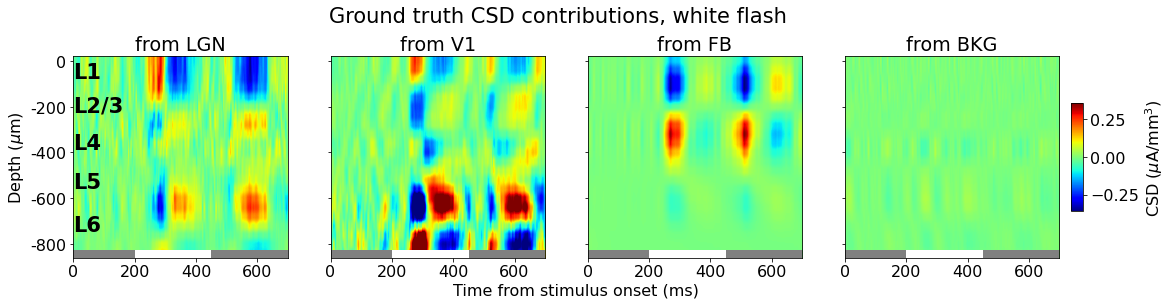

In [801]:
nchan_lim = 22

corr_pops_pen_dict = dict()
rel_MSE_pops_pen_dict = dict()

csd_lpa_pen_dict = dict()

istim = 0

#if pen_fac == pen_facs[-1]:
fig, axes = plt.subplots(nrows = 1, ncols = npop_guess+3, figsize = (5.5*(npop_guess+2),4.3), sharex = True, sharey = True)

tstim_onset = 200
scale_to_uA = 1E-3

rel_MSE_pops = dict()
corr_pops = dict()

csd_sims_gt_v1_summed = csd_gt_flashes[flash_types[istim]]

for isim, sim_name in enumerate(csd_sims_gt_v1_summed.keys()):
    csd_sim = csd_sims_gt_v1_summed[sim_name]['trial_avg'][:nchan_lim]*scale_to_uA #tstim_onset:tstim_onset+101]

    #if 'LGN' not in sim_name:
    #    csd_sim = gaussian_filter(csd_sim, sigma = (1.4,0))

    icol = isim % 4

    ax = axes[icol]

    if icol == 0:
        ax.set_yticks(yticks)
        ax.set_yticklabels(ytick_labels)
        ax.set_ylabel('Depth ($\mu$m)')

    if isim == 0:
        cmap_range_gt = np.abs(csd_sim).max()

    im = ax.imshow(csd_sim, cmap = 'jet', aspect = 'auto', vmin = -cmap_range_gt, vmax = cmap_range_gt)

    ax.set_title('from '+sim_name)

    if icol == 0:
        ax.set_yticks(yticks)
        ax.set_yticklabels(ytick_labels)
        ax.set_ylabel('Depth ($\mu$m)')
        
    if istim == 0:
        ax.hlines(y = 21.1, xmin = 0, xmax = tstim_onset, linewidth = 8.0, colors = 'gray')
        ax.hlines(y = 21.1, xmin = tstim_onset, xmax = tstim_onset+250, linewidth = 8.0, colors = 'white')
        ax.hlines(y = 21.1, xmin = tstim_onset+250, xmax = 700, linewidth = 8.0, colors = 'gray')
    elif istim == 1:
        ax.hlines(y = 21.1, xmin = 0, xmax = tstim_onset, linewidth = 8.0, colors = 'gray')
        ax.hlines(y = 21.1, xmin = tstim_onset, xmax = tstim_onset+250, linewidth = 8.0)
        ax.hlines(y = 21.1, xmin = tstim_onset+250, xmax = 700, linewidth = 8.0, colors = 'gray')


#corr_pops_pen_dict[pen_fac] = corr_pops
#rel_MSE_pops_pen_dict[pen_fac] = rel_MSE_pops

#ax.set_xticks(np.arange(0,csd_lpa_pop_est.shape[1],200))
#ax.set_xticklabels(np.arange(0,csd_lpa_pop_est.shape[1],200)-200)

plt.figtext(s = 'Ground truth CSD contributions, '+flash_types[istim]+' flash', x = 0.285, y = 0.91, fontsize = 21)
plt.figtext(s = 'Time from stimulus onset (ms)', x = 0.39, y = 0.03)

cbaxes = fig.add_axes([0.91,0.3,0.01, 0.35])
cb = fig.colorbar(im, ax = ax, cax = cbaxes)
cb.set_label('CSD ($\mu$A/mm$^3$)')

ax.set_xlim([0, csd_sim.shape[1]-1])

for i in range(1,2):
    plt.figtext(x = 0.07, y = 1.13-i*0.4, s = 'L1', fontsize = 21, fontweight = 560)
    plt.figtext(x = 0.07, y = 1.02-i*0.4, s = 'L2/3', fontsize = 21, fontweight = 560)
    plt.figtext(x = 0.07, y = 0.9-i*0.4, s = 'L4', fontsize = 21, fontweight = 560)
    plt.figtext(x = 0.07, y = 0.775-i*0.4, s = 'L5', fontsize = 21, fontweight = 560)
    plt.figtext(x = 0.07, y = 0.635-i*0.4, s = 'L6', fontsize = 21, fontweight = 560)

fig.subplots_adjust(left = 0.07, right = 0.9, bottom = 0.15, top = 0.8)

#fig_name = 'csd_LPA_est_pop_contribs_white_flash_'+config_name+'_w_rel_MSE_lamda'+str(np.round(pen_fac, 4))+'.png'

fig_name = 'csd_ground_truth_est_pop_contribs_'+flash_types[istim]+'_flash.png'

if istim == 0:
    savepath = os.path.join(fig_dir, 'pop_est', flash_types[istim])
else:
    savepath = os.path.join(fig_dir.rsplit('/', 1)[0], 'Supplementary_figures', 'pop_est', flash_types[istim])

if not os.path.exists(savepath):
    if not os.path.exists(savepath.rsplit('/', 1)[0]):
        os.mkdir(savepath.rsplit('/', 1)[0])
        os.mkdir(savepath)
    else:
        os.mkdir(savepath)

savepath = os.path.join(savepath, fig_name)

#if pen_fac == pen_facs[-1]:
#fig.savefig(savepath, facecolor = 'w') 

In [802]:
csd_rel_MSE_ica_pops = np.zeros((2,2,4,4))
csd_corr_ica_pops = np.zeros((2,2,4,4))

for iflash, flash_type in enumerate(csd_gt_flashes.keys()):
    for ipop, pop_name in enumerate(csd_gt_flashes[flash_type].keys()):
        
        csd_gt_pop = csd_gt_flashes[flash_type][pop_name]['trial_avg'][:nchan_lim]
        
        for istim, stim_name in enumerate(csd_sims_recon.keys()):
            
            csd_recon = csd_sims_recon[stim_name]
    
            for compNr in range(n_components):
                csd_recon_comp = csd_recon[compNr]
                
                diff = csd_gt_pop - csd_recon_comp
                rel_MSE = np.sum(diff**2)/np.sum(csd_gt_pop**2)
                corr = np.corrcoef(csd_gt_pop.flatten(), csd_recon_comp.flatten())[0,1]

                csd_rel_MSE_ica_pops[iflash, istim, ipop, compNr] = rel_MSE
                csd_corr_ica_pops[iflash, istim, ipop, compNr] = corr

In [671]:
layer_names_w_L = ['LGN', 'V1', 'FB', 'BKG']

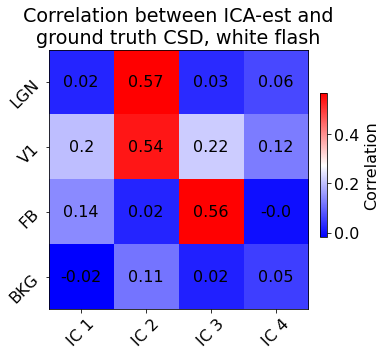

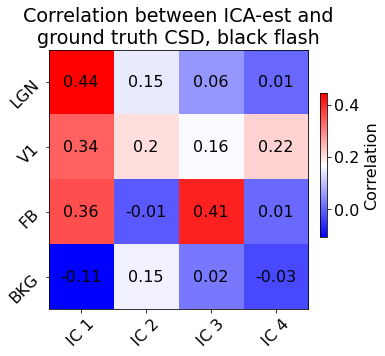

In [672]:
for iflash, istim in zip(range(2), range(2)):
    fig, ax = plt.subplots(figsize = (5.3,5))

    im = ax.imshow(csd_corr_ica_pops[iflash, istim], cmap = 'bwr')

    ax.set_title('Correlation between ICA-est and\nground truth CSD, '+flash_types[iflash]+ ' flash')

    cbaxes = fig.add_axes([0.83, 0.33, 0.02, 0.4])
    cb = fig.colorbar(im, ax = ax, cax = cbaxes)
    cb.set_label('Correlation')

    for (j,i),label in np.ndenumerate(csd_corr_ica_pops[iflash, istim]):
        label = np.round(label,2)
        ax.text(i,j,label,ha='center',va='center')

    ax.set_xticks(np.arange(4))
    ax.set_xticklabels(['IC 1', 'IC 2', 'IC 3', 'IC 4'], rotation = 45)
    ax.set_yticks(np.arange(len(layer_names_w_L)))
    ax.set_yticklabels(layer_names_w_L, rotation = 45)
    
    fig.subplots_adjust(left = 0.12, right = 0.8, bottom = 0.1, top = 0.88)
    
    fig_name = 'corr_ica_comps_and_ground_truth_4comps_'+str(flash_types[istim])+'.png'
    
    savepath = os.path.join(fig_dir, 'ICA', 'correlation', fig_name)
    
    #fig.savefig(savepath, facecolor = 'w')

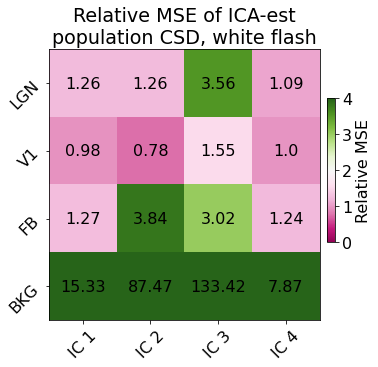

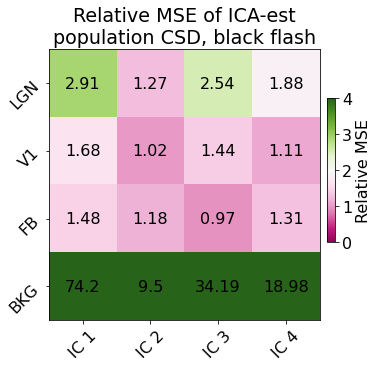

In [673]:
for iflash, istim in zip(range(2), range(2)):
    fig, ax = plt.subplots(figsize = (5.3,5))

    im = ax.imshow(csd_rel_MSE_ica_pops[iflash, istim], vmin = 0, vmax = 4, cmap = 'PiYG')

    ax.set_title('Relative MSE of ICA-est\npopulation CSD, '+flash_types[iflash]+ ' flash')
    cbaxes = fig.add_axes([0.85, 0.33, 0.02, 0.4])
    cb = fig.colorbar(im, ax = ax, cax = cbaxes)
    cb.set_label('Relative MSE')

    for (j,i),label in np.ndenumerate(csd_rel_MSE_ica_pops[iflash, istim]):
        label = np.round(label,2)
        ax.text(i,j,label,ha='center',va='center')

    ax.set_xticks(np.arange(4))
    ax.set_xticklabels(['IC 1', 'IC 2', 'IC 3', 'IC 4'], rotation = 45)
    ax.set_yticks(np.arange(len(layer_names_w_L)))
    ax.set_yticklabels(layer_names_w_L, rotation = 45)
    
    fig.subplots_adjust(left = 0.12, right = 0.83, bottom = 0.1, top = 0.88)

    fig_name = 'rel_MSE_ica_comps_and_ground_truth_4comps_'+str(flash_types[istim])+'.png'
    
    savepath = os.path.join(fig_dir, 'ICA', 'relative_MSE', fig_name)
    
    #fig.savefig(savepath, facecolor = 'w')

In [675]:
csd_sims_arr_flat

array([[ 0.01414309,  0.03302003,  0.04684204, ...,  0.0034282 ,
        -0.01853735, -0.03574539],
       [ 0.01209564,  0.01833097,  0.0212589 , ..., -0.00328092,
        -0.01524979, -0.02865582],
       [-0.00487825, -0.00938554, -0.0156667 , ...,  0.00894718,
         0.01462833,  0.00813891],
       ...,
       [-0.05945648, -0.06298736, -0.05258327, ...,  0.07879118,
         0.07881906,  0.07633294],
       [-0.04954137, -0.05601639, -0.05657276, ...,  0.12065826,
         0.10628867,  0.10420841],
       [-0.03287114, -0.05172721, -0.06576631, ...,  0.10592453,
         0.09313594,  0.10741748]])

### PCA

In [823]:
from scipy.linalg import svd
# calculate the SVD and plot the image
U, S, V_T = svd(csd_sims_arr_flat, full_matrices=False)
S = np.diag(S)


In [824]:
explained_variance_ = (S ** 2) / n_samples
explained_variance_ratio_ = (explained_variance_ /
                             explained_variance_.sum())

In [828]:
np.diag(explained_variance_ratio_ )[:4].sum()

0.9622553485281202

In [816]:
U.shape, S.shape, V_T.shape

((22, 22), (22, 22), (22, 1400))

In [701]:
csd_pca_recon = []

for compNr in range(1, 5):
    csd_pca_recon.append(U[:, (compNr-1):compNr] @ S[(compNr-1):compNr, (compNr-1):compNr] @ V_T[(compNr-1):compNr, :])

csd_pca_recon = np.array(csd_pca_recon)

In [703]:
csd_sims_arr_flat

array([[ 0.01414309,  0.03302003,  0.04684204, ...,  0.0034282 ,
        -0.01853735, -0.03574539],
       [ 0.01209564,  0.01833097,  0.0212589 , ..., -0.00328092,
        -0.01524979, -0.02865582],
       [-0.00487825, -0.00938554, -0.0156667 , ...,  0.00894718,
         0.01462833,  0.00813891],
       ...,
       [-0.05945648, -0.06298736, -0.05258327, ...,  0.07879118,
         0.07881906,  0.07633294],
       [-0.04954137, -0.05601639, -0.05657276, ...,  0.12065826,
         0.10628867,  0.10420841],
       [-0.03287114, -0.05172721, -0.06576631, ...,  0.10592453,
         0.09313594,  0.10741748]])

In [707]:
csd_pca_recon_flashes

{'white': array([[[ 0.02413012,  0.03387908,  0.03766386, ..., -0.08824713,
          -0.09702119, -0.10906582],
         [ 0.02608119,  0.03661842,  0.04070922, ..., -0.09538247,
          -0.10486597, -0.11788447],
         [ 0.02287471,  0.03211647,  0.03570434, ..., -0.08365594,
          -0.09197352, -0.1033915 ],
         ...,
         [-0.01038007, -0.01457379, -0.01620189, ...,  0.03796134,
           0.04173568,  0.04691693],
         [-0.02784624, -0.03909657, -0.04346422, ...,  0.10183749,
           0.11196279,  0.12586233],
         [-0.03957522, -0.05556425, -0.06177157, ...,  0.14473196,
           0.15912209,  0.17887618]],
 
        [[-0.02737115, -0.03162905, -0.03105454, ...,  0.05288569,
           0.04573988,  0.03767183],
         [-0.03102216, -0.03584802, -0.03519688, ...,  0.05994007,
           0.05184109,  0.04269684],
         [-0.0346879 , -0.04008401, -0.03935593, ...,  0.0670229 ,
           0.0579669 ,  0.04774212],
         ...,
         [-0.00205127, -

In [708]:
csd_pca_recon

array([[[ 0.02413012,  0.03387908,  0.03766386, ..., -0.07996059,
         -0.08167055, -0.08871008],
        [ 0.02608119,  0.03661842,  0.04070922, ..., -0.0864259 ,
         -0.08827412, -0.09588285],
        [ 0.02287471,  0.03211647,  0.03570434, ..., -0.07580052,
         -0.07742151, -0.0840948 ],
        ...,
        [-0.01038007, -0.01457379, -0.01620189, ...,  0.03439671,
          0.03513228,  0.03816048],
        [-0.02784624, -0.03909657, -0.04346422, ...,  0.09227479,
          0.09424809,  0.10237173],
        [-0.03957522, -0.05556425, -0.06177157, ...,  0.1311414 ,
          0.13394587,  0.14549123]],

       [[-0.02737115, -0.03162905, -0.03105454, ...,  0.08547918,
          0.0832298 ,  0.08208479],
        [-0.03102216, -0.03584802, -0.03519688, ...,  0.09688118,
          0.09433176,  0.09303401],
        [-0.0346879 , -0.04008401, -0.03935593, ...,  0.10832917,
          0.10547849,  0.10402739],
        ...,
        [-0.00205127, -0.00237037, -0.00232732, ...,  

In [705]:
#csd_pca_recon_flashes = np.zeros((2, n_components, nchan_lim, int(csd_pca_recon.shape[-1]/2)))
csd_pca_recon_flashes = dict()

for istim in range(2):
    csd_pca_recon_flashes[flash_types[istim]] = csd_pca_recon[:,:,istim*700:(istim+1)*700]

In [616]:
(U @ S @ V_T).shape

(22, 1400)

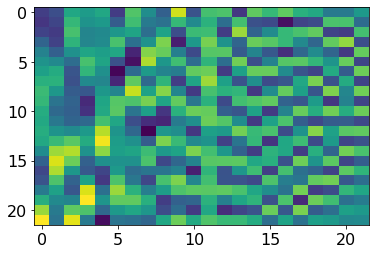

In [580]:
plt.imshow(U, aspect = 'auto',)

In [570]:
U.shape

(22, 22)

In [571]:
S.shape

(22,)

In [572]:
Vh.shape

(1400, 1400)

In [575]:
np.dot(np.dot(U,S), Vh.T)

ValueError: shapes (22,) and (1400,1400) not aligned: 22 (dim 0) != 1400 (dim 0)

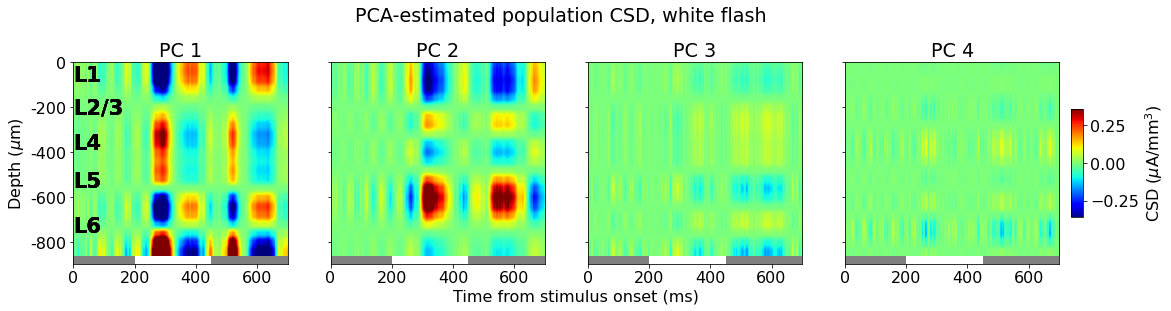

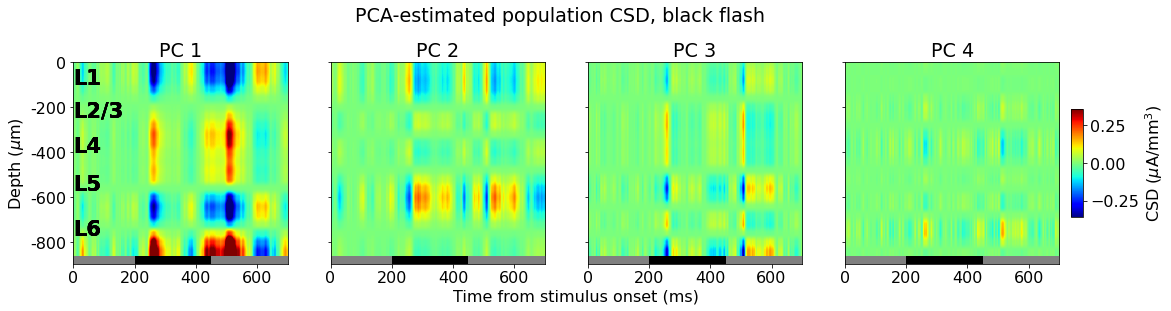

In [805]:

tstim_onset = 200
scale_to_uA = 1E-4

for istim, stim_name in enumerate(csd_pca_recon_flashes.keys()):
    fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize = (5.5*3,4.3), sharex = True, sharey = True)
        
    csd_recon = csd_pca_recon_flashes[stim_name]
    
    for compNr in range(n_components):
        ax = axes[compNr]
        
        csd_plot = csd_recon[compNr]# * scale_to_uA
        
        if compNr == 0 and istim == 0:
            cmap_range = np.abs(csd_plot).max()/2
    
        im = ax.imshow(csd_plot, cmap = 'jet', vmin = -cmap_range_gt, vmax = cmap_range_gt, aspect = 'auto')
        
        if compNr == 0:
            ax.set_yticks(yticks)
            ax.set_yticklabels(ytick_labels)
            ax.set_ylabel('Depth ($\mu$m)')
            
        if istim == 0:
            ax.hlines(y = 22.03, xmin = 0, xmax = tstim_onset, linewidth = 8.0, colors = 'gray')
            ax.hlines(y = 22.03, xmin = tstim_onset, xmax = tstim_onset+250, linewidth = 8.0, colors = 'white')
            ax.hlines(y = 22.03, xmin = tstim_onset+250, xmax = 700, linewidth = 8.0, colors = 'gray')
        elif istim == 1:
            ax.hlines(y = 22.03, xmin = 0, xmax = tstim_onset, linewidth = 8.0, colors = 'gray')
            ax.hlines(y = 22.03, xmin = tstim_onset, xmax = tstim_onset+250, linewidth = 8.0)
            ax.hlines(y = 22.03, xmin = tstim_onset+250, xmax = 700, linewidth = 8.0, colors = 'gray')
            
        ax.set_ylim([22.4, 0])
        ax.set_xlim([0, 700])
                
        plt.figtext(x = 0.07, y = 0.74-istim*0.01, s = 'L1', fontsize = 21, fontweight = 560)
        plt.figtext(x = 0.07, y = 0.635-istim*0.01, s = 'L2/3', fontsize = 21, fontweight = 560)
        plt.figtext(x = 0.07, y = 0.52-istim*0.01, s = 'L4', fontsize = 21, fontweight = 560)
        plt.figtext(x = 0.07, y = 0.395-istim*0.01, s = 'L5', fontsize = 21, fontweight = 560)
        plt.figtext(x = 0.07, y = 0.25-istim*0.01, s = 'L6', fontsize = 21, fontweight = 560)
        
        ax.set_title('PC '+str(compNr+1))
    
    cbaxes = fig.add_axes([0.91,0.3,0.01, 0.35])
    cb = fig.colorbar(im, ax = ax, cax = cbaxes)
    cb.set_label('CSD ($\mu$A/mm$^3$)')
        
    plt.figtext(s = 'Time from stimulus onset (ms)', x = 0.39, y = 0.03)
        
    fig.subplots_adjust(left = 0.07, right = 0.9, bottom = 0.15, top = 0.8)
    
    fig.suptitle('PCA-estimated population CSD, '+flash_types[istim]+' flash', x = 0.48, y = 0.98)
    
    fig_name = 'pca_est_pop_csd_'+str(flash_types[istim])+'_flashes.png'
    
    savepath = os.path.join(fig_dir, 'PCA')
    
    if not os.path.exists(savepath):
        if not os.path.exists(savepath.rsplit('/', 1)[0]):
            os.mkdir(savepath.rsplit('/', 1)[0])
            os.mkdir(savepath)
        elif not os.path.exists(savepath.rsplit('/', 1)[0].rsplit('/', 1)[0]):
            os.mkdir(savepath.rsplit('/', 1)[0].rsplit('/', 1)[0])
            os.mkdir(savepath)
        else:
            os.mkdir(savepath)
            
    savepath = os.path.join(savepath, fig_name)
    
    #fig.savefig(savepath, facecolor = 'w')

In [742]:
csd_gt_pop

array([[-0.00771625,  0.00235351,  0.01180629, ...,  0.00629496,
         0.00420174,  0.00184079],
       [-0.00666509,  0.00161002,  0.00962003, ...,  0.00770334,
         0.00546361,  0.0026463 ],
       [-0.00446706, -0.00148828,  0.00205042, ...,  0.00784532,
         0.00600918,  0.00283483],
       ...,
       [-0.00594378, -0.00746123, -0.00920045, ...,  0.00366754,
         0.0034142 ,  0.00343834],
       [-0.00824179, -0.01080693, -0.0129677 , ...,  0.00500494,
         0.00563801,  0.00636995],
       [-0.00535852, -0.00718016, -0.008354  , ...,  0.00393635,
         0.00484826,  0.00562612]])

In [786]:
csd_rel_MSE_pca_pops = np.zeros((2,2,4,4))
csd_corr_pca_pops = np.zeros((2,2,4,4))

for iflash, flash_type in enumerate(csd_gt_flashes.keys()):
    for ipop, pop_name in enumerate(csd_gt_flashes[flash_type].keys()):
        
        csd_gt_pop = csd_gt_flashes[flash_type][pop_name]['trial_avg'][:nchan_lim]*1E-3
        
        for istim, stim_name in enumerate(csd_pca_recon_flashes.keys()):
            
            csd_recon = csd_pca_recon_flashes[stim_name]
    
            for compNr in range(n_components):
                csd_recon_comp = csd_recon[compNr]
                
                diff = csd_gt_pop - csd_recon_comp
                rel_MSE = np.sum(diff**2)/np.sum(csd_gt_pop**2)
                corr = np.corrcoef(csd_gt_pop.flatten(), csd_recon_comp.flatten())[0,1]

                csd_rel_MSE_pca_pops[iflash, istim, ipop, compNr] = rel_MSE
                csd_corr_pca_pops[iflash, istim, ipop, compNr] = corr

In [787]:
csd_recon_comp.max()

0.1801633040140362

In [784]:
csd_gt_pop = csd_gt_flashes[flash_type]['LGN']['trial_avg'][:nchan_lim]*1E-3

In [785]:
csd_gt_pop.max()

0.17959502099234886

In [773]:
npop_guess = 1

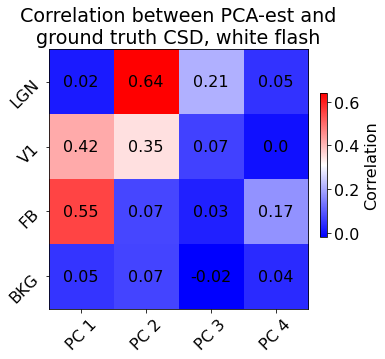

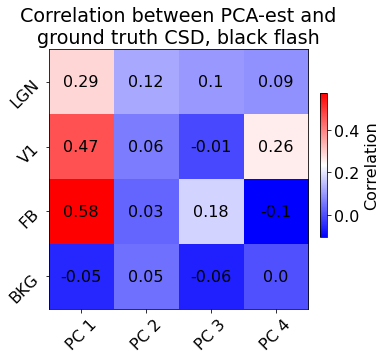

In [791]:
for iflash, istim in zip(range(2), range(2)):
    fig, ax = plt.subplots(figsize = (5.3,5))

    im = ax.imshow(csd_corr_pca_pops[iflash, istim], cmap = 'bwr')

    ax.set_title('Correlation between PCA-est and\nground truth CSD, '+flash_types[iflash]+ ' flash')

    cbaxes = fig.add_axes([0.83, 0.33, 0.02, 0.4])
    cb = fig.colorbar(im, ax = ax, cax = cbaxes)
    cb.set_label('Correlation')

    for (j,i),label in np.ndenumerate(csd_corr_pca_pops[iflash, istim]):
        label = np.round(label,2)
        ax.text(i,j,label,ha='center',va='center')

    ax.set_xticks(np.arange(4))
    ax.set_xticklabels(['PC 1', 'PC 2', 'PC 3', 'PC 4'], rotation = 45)
    ax.set_yticks(np.arange(len(layer_names_w_L)))
    ax.set_yticklabels(layer_names_w_L, rotation = 45)
    
    fig.subplots_adjust(left = 0.12, right = 0.8, bottom = 0.1, top = 0.88)
    
    fig_name = 'corr_pca_comps_and_ground_truth_4comps_'+str(flash_types[istim])+'.png'
    
    savepath = os.path.join(fig_dir, 'PCA', 'correlation', fig_name)
    
    #fig.savefig(savepath, facecolor = 'w')

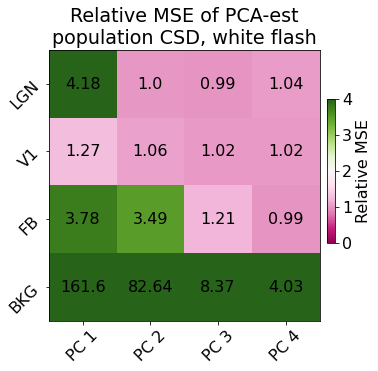

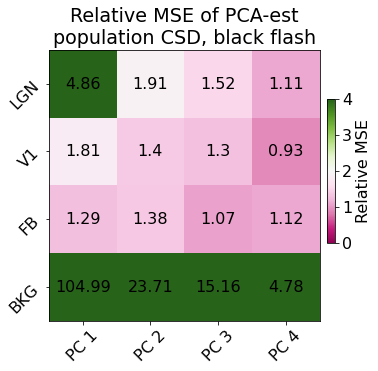

In [795]:
for iflash, istim in zip(range(2), range(2)):
    fig, ax = plt.subplots(figsize = (5.3,5))

    im = ax.imshow(csd_rel_MSE_pca_pops[iflash, istim], vmin = 0, vmax = 4, cmap = 'PiYG')

    ax.set_title('Relative MSE of PCA-est\npopulation CSD, '+flash_types[iflash]+ ' flash')
    cbaxes = fig.add_axes([0.85, 0.33, 0.02, 0.4])
    cb = fig.colorbar(im, ax = ax, cax = cbaxes)
    cb.set_label('Relative MSE')

    for (j,i),label in np.ndenumerate(csd_rel_MSE_pca_pops[iflash, istim]):
        label = np.round(label,2)
        ax.text(i,j,label,ha='center',va='center')

    ax.set_xticks(np.arange(4))
    ax.set_xticklabels(['PC 1', 'PC 2', 'PC 3', 'PC 4'], rotation = 45)
    ax.set_yticks(np.arange(len(layer_names_w_L)))
    ax.set_yticklabels(layer_names_w_L, rotation = 45)
    
    fig.subplots_adjust(left = 0.12, right = 0.83, bottom = 0.1, top = 0.88)

    fig_name = 'rel_MSE_pca_comps_and_ground_truth_4comps_'+str(flash_types[istim])+'.png'
        
    savepath = os.path.join(fig_dir, 'PCA', 'relative_MSE', fig_name)
    
    #fig.savefig(savepath, facecolor = 'w')

In [ ]:
csd_sims_arr_flat_for_pca

In [282]:
np.dot(pca.components_[0], csd_sims_arr_flat.T)

(22,)

In [45]:
csd_ica_recon.shape

(22, 700)

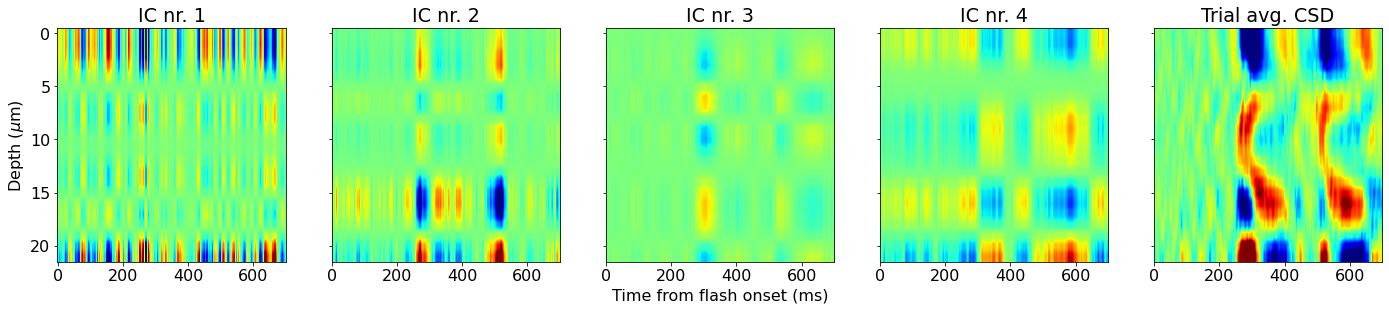

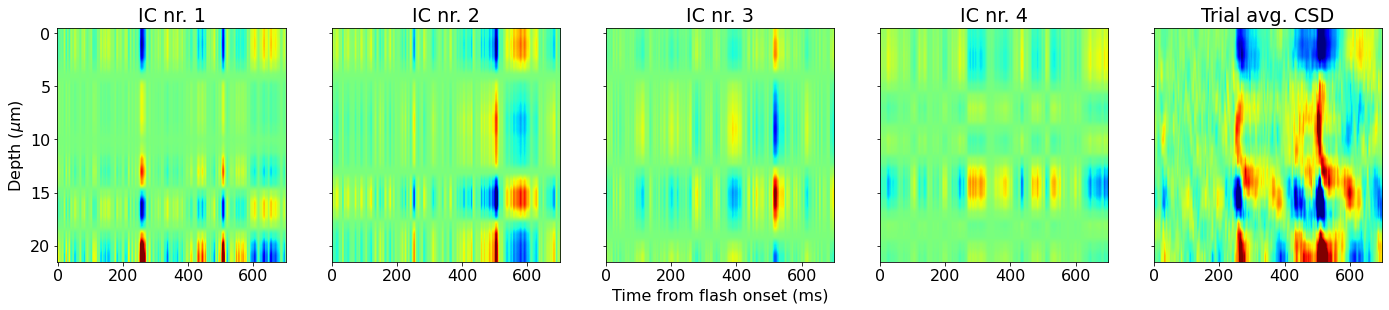

In [48]:
for sim_name in sims_mixing_mat.keys():
    mixing_mat = sims_mixing_mat[sim_name]
    X_transformed = sims_csd_ica[sim_name]

    fig, axes = plt.subplots(nrows = 1, ncols = n_components+1, figsize = (4*(n_components+1),5), sharey = True)
    
    for compNr in range(n_components):
        ax = axes[compNr]
        csd_ica_recon = np.outer(mixing_mat[:,compNr], X_transformed[compNr])

        if compNr == 0:
            cmap_range = np.abs(csd_ica_recon).max()/2
            csd_ica_recon_sum = csd_ica_recon
            ax.set_ylabel('Depth ($\mu$m)')
        else:
            csd_ica_recon_sum += csd_ica_recon
            
        if compNr == 2:
            ax.set_xlabel('Time from flash onset (ms)')

        ax.imshow(csd_ica_recon, aspect = 'auto', cmap = 'jet', vmin = -cmap_range, vmax = cmap_range)
        
        #ax.set_xticks(np.arange(0,120,20))
                
        ax.set_title('IC nr. '+str(compNr+1))
        
    ax = axes[-1]
    #ax.imshow(csd_ica_recon_sum, aspect = 'auto', cmap = 'jet', vmin = -cmap_range, vmax = cmap_range)

    csd_sim = csd_sims[sim_name]
    
    #if 'final' in sim_name:
    #    cmap_range = np.abs(csd_sim_interp).max()/2.2
    #else:
    #    cmap_range = np.abs(csd_sim_interp).max()/1.3
    ax.imshow(csd_sim, aspect = 'auto', cmap = 'jet', vmin = -cmap_range, vmax = cmap_range)
    
    #ax.set_yticks(np.arange(0,30,6))
    #ax.set_yticklabels(-np.arange(0,1000,200))
    
    ax.set_title('Trial avg. CSD')
    
    #fig.suptitle(sims_labels[sim_name], x = 0.495, y = 0.99)
    
    fig.subplots_adjust(left = 0.05, right = 0.97, bottom = 0.15, top = 0.8)
    
    fig_name = 'ICA_decomp_'+str(n_components)+'comps_'+sim_name+'.png'
    
    savepath = os.path.join(fig_dir, 'ICA', fig_name)
    
    #fig.savefig(savepath, facecolor = 'w')